In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from pymongo import MongoClient
import plotly

In [2]:
#Initialize database
client = MongoClient()
db = client.crypto

#Insert Tables
prices = db.prices
block_size = db.blocksize
avg_block_size = db.avgblocksize
n_trans = db.ntrans
n_payments = db.npayments
total_n_trans = db.totalntrans
med_confirm = db.medconfirm
avg_confirm = db.avgconfirm
news = db.news

#Plot the predictions
def plot_predictions(test, filename, predicted=None, save=False):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,4))
    plt.plot(test, "-", label='Real BTC Price')
    if predicted is not None:
        plt.plot(predicted, ".", label='Predicted BTC Price')
    plt.title('BTC Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('BTC Price')
    plt.xticks(rotation=45)
    plt.legend()
    if save == True:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

#Calculate the RMSE
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

#Plot the autocorrelation    
def tmplot(y, title, filename, lags=None, figsize=(12,8), save=False):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    y.plot(ax=ts_ax);
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=5)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    if save == True:
        plt.savefig(filename,bbox_inches='tight')
    plt.show()
    return (ts_ax, acf_ax, pacf_ax)

#Plot the model loss
def plot_loss(history, label, n):
    plt.tight_layout()
    plt.figure(figsize=(12, 8))
    plt.semilogy(history.epoch, history.history['loss'], color='blue',
                 label='Train ' + label)
    #plt.semilogy(history.epoch, history.history['val_loss'], color='orange',
                 #label='Val ' + label,
                 #linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
#Calculate Returns
def returns(df, interval=1):
    diff = list()
    for i in range(interval, len(df)):
        value = np.log(df[i]/df[i - interval])
        diff.append(value)
    return diff    

#Difference the data
def difference(df, interval=1):
    diff = list()
    for i in range(interval, len(df)):
        value = df[i] - df[i - interval]
        diff.append(value)
    return diff

#Reverse the differencing for the train set
def rev_dif(df, pred, interval=1):
    inv_diff = list()
    for i in range(len(df)-len(pred), len(df)):
        value = df[i] - pred[(i - (len(df)-len(pred)) + interval) - interval]
        inv_diff.append(value)
    return inv_diff

#Reverse the differencing for predictions
def rev_diff_pred(df, pred, interval=1):
    pred[0] = df[-interval]
    for i in range(1, len(pred)):
        pred[i] = pred[i-interval] - pred[i]
    return pred

#Split and process the data
def train_test(dataset, split=.8):
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train, test
def process(dataset, samples):
    dataX = []
    dataY = []
    for i in range(len(dataset)-samples):
        dataX.append(dataset[i:(i+samples)])
        dataY.append(dataset[i+samples])
    return np.array(dataX), (np.array(dataY).reshape(np.array(dataY).shape[0],-1))

#Unscale
def unscale(dataset):
    copy = np.repeat(dataset, X_train_scaled.shape[1], axis=-1)
    return copy

In [3]:
%%time
dataset = list(prices.find({}))

Wall time: 26.5 ms


In [4]:
list(prices.find({}))[-1]['close']

57367.32

In [5]:
print(dataset)

[{'_id': ObjectId('616047c85ea4d98b60046477'), 'unix': 1461974400, 'low': 450.13, 'high': 459.33, 'open': 458.8, 'close': 454.02, 'volume': 4710.2895045, 'date': datetime.datetime(2016, 4, 30, 0, 0), 'vol_fiat': 2138565.6408330896}, {'_id': ObjectId('616047c85ea4d98b60046478'), 'unix': 1461888000, 'low': 448.5, 'high': 459.44, 'open': 451.67, 'close': 458.82, 'volume': 5965.09735013, 'date': datetime.datetime(2016, 4, 29, 0, 0), 'vol_fiat': 2736905.966186647}, {'_id': ObjectId('616047c85ea4d98b60046479'), 'unix': 1461801600, 'low': 434.79, 'high': 451.88, 'open': 445.3, 'close': 451.68, 'volume': 7644.69210461, 'date': datetime.datetime(2016, 4, 28, 0, 0), 'vol_fiat': 3452954.5298102447}, {'_id': ObjectId('616047c85ea4d98b6004647a'), 'unix': 1461715200, 'low': 434.0, 'high': 470.79, 'open': 470.3, 'close': 445.31, 'volume': 11629.49770098, 'date': datetime.datetime(2016, 4, 27, 0, 0), 'vol_fiat': 5178731.621223404}, {'_id': ObjectId('616047c85ea4d98b6004647b'), 'unix': 1461628800, 'low

In [5]:
print(dataset[-1]['close'])

57367.32


In [15]:
df = pd.DataFrame(columns=['date','low','high','open','close','vol_fiat'])
for i in dataset:
    row = {'date':i['date'],'low':i['low'],'high':i['high'],'open':i['open'],'close':i['close'],'vol_fiat':i['vol_fiat']}
    df = df.append(row, ignore_index=True)
df.drop_duplicates(subset=['date'], keep='last', inplace=True)
df = df.set_index('date', drop=True).sort_index()


In [16]:
df

,low,high,open,close,vol_fiat
date,,,,,
2015-07-30,286.56,291.56,290.26,288.49,1.482545e+06
2015-07-31,282.79,290.00,288.49,285.19,1.618915e+06
2015-08-01,277.26,285.60,285.20,281.53,1.107103e+06
2015-08-02,277.33,282.62,281.53,282.62,9.499103e+05
2015-08-03,280.27,285.86,282.62,280.95,1.332189e+06
...,...,...,...,...,...
2021-10-10,54112.95,56545.24,54963.29,54690.53,5.124607e+08
2021-10-11,54411.54,57833.23,54683.09,57487.44,7.716206e+08
2021-10-12,53873.78,57674.55,57485.97,56005.10,8.656713e+08


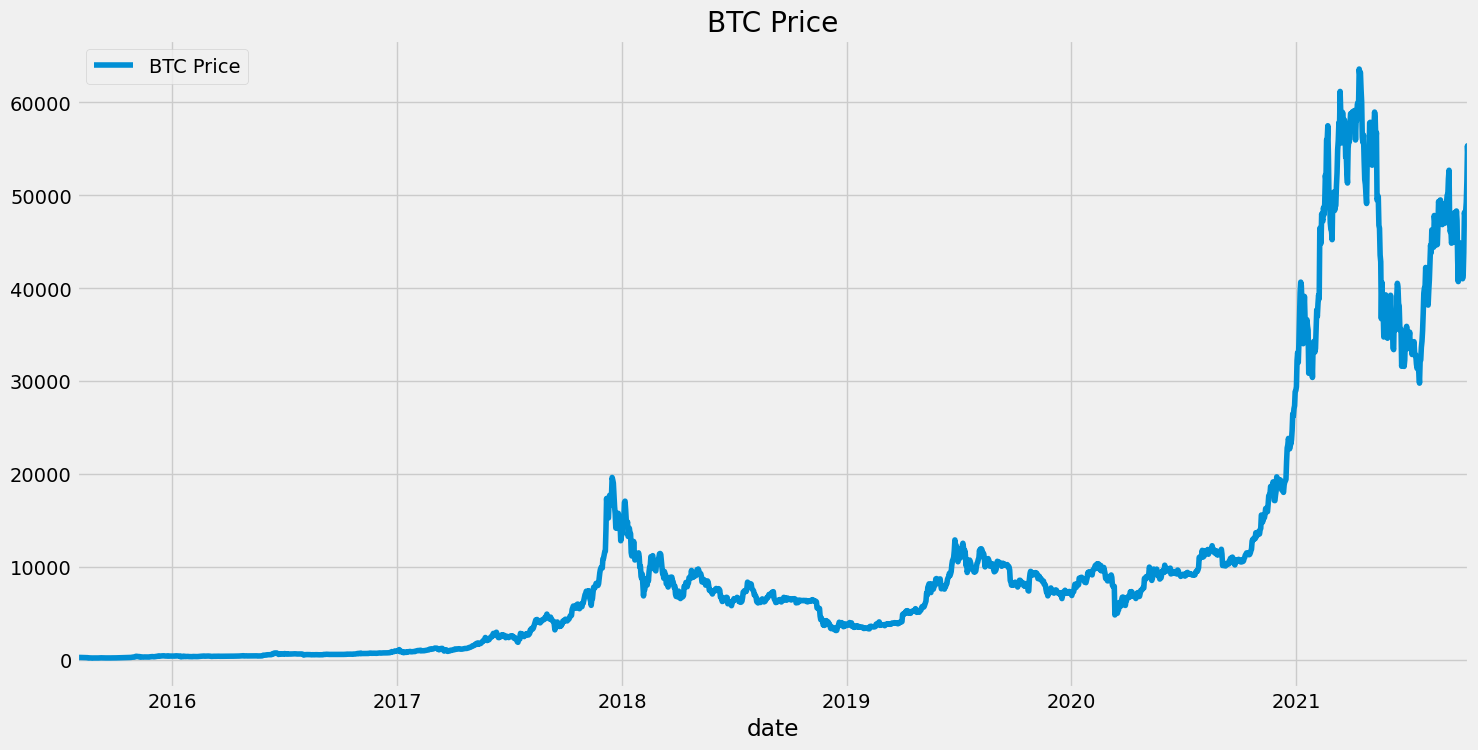

In [9]:
#Plot the data
plt.style.use('fivethirtyeight')
df.close.plot(figsize=(16,8),legend=True)
plt.legend(['BTC Price'])
plt.title('BTC Price')
plt.show()

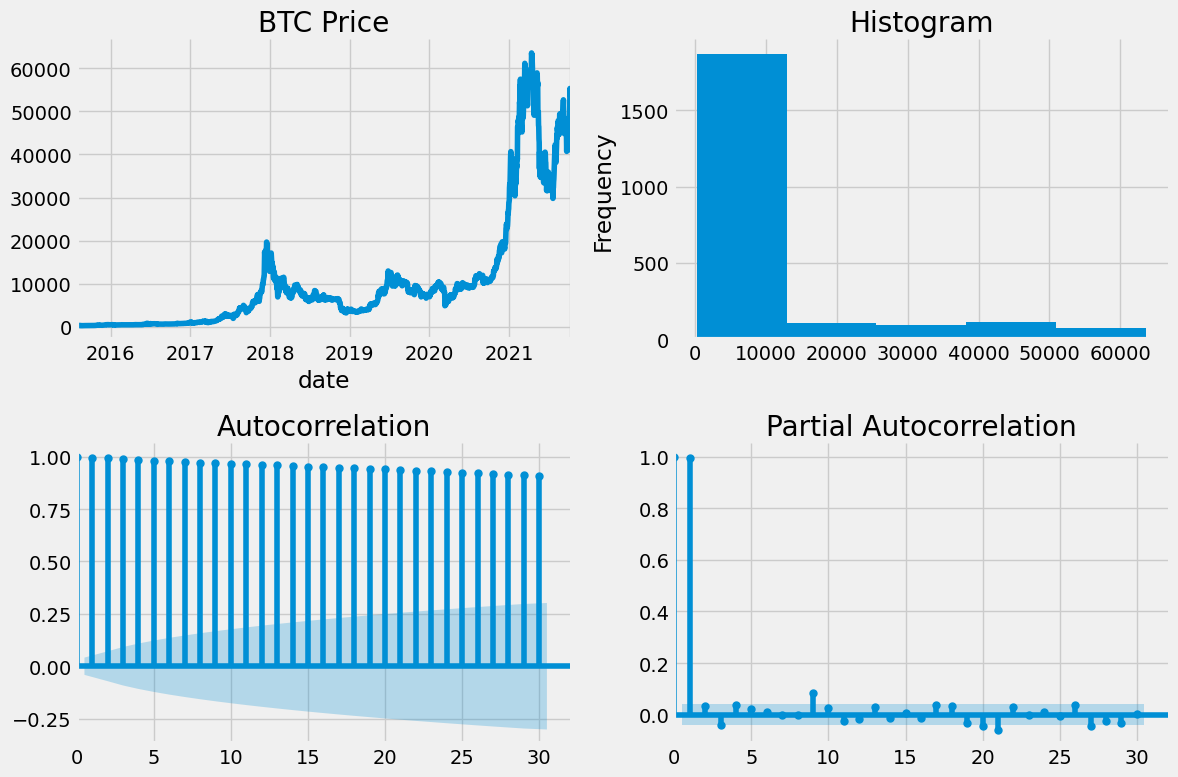

Wall time: 4.03 s


(<AxesSubplot:title={'center':'BTC Price'}, xlabel='date'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

In [10]:
%%time
tmplot(df.close,'BTC Price','BTC_Auto_Corr.png',lags=30,save=True)

In [11]:
#Difference the data to make it stationary
df['close_shift'] = pd.Series(difference(df.close, interval=1), index=df.index[1:])
df['returns'] = pd.Series(returns(df.close, interval=1), index=df.index[1:])
df

,low,high,open,close,vol_fiat,close_shift,returns
date,,,,,,,
2015-07-30,286.56,291.56,290.26,288.49,1.482545e+06,NaN,NaN
2015-07-31,282.79,290.00,288.49,285.19,1.618915e+06,-3.30,-0.011505
2015-08-01,277.26,285.60,285.20,281.53,1.107103e+06,-3.66,-0.012917
2015-08-02,277.33,282.62,281.53,282.62,9.499103e+05,1.09,0.003864
2015-08-03,280.27,285.86,282.62,280.95,1.332189e+06,-1.67,-0.005927
...,...,...,...,...,...,...,...
2021-10-04,46916.70,49505.00,48233.99,49245.54,6.864159e+08,1011.55,0.020755
2021-10-05,49057.18,51906.23,49244.13,51493.99,9.180656e+08,2248.45,0.044646
2021-10-06,50416.01,55757.11,51499.77,55339.48,1.431613e+09,3845.49,0.072021


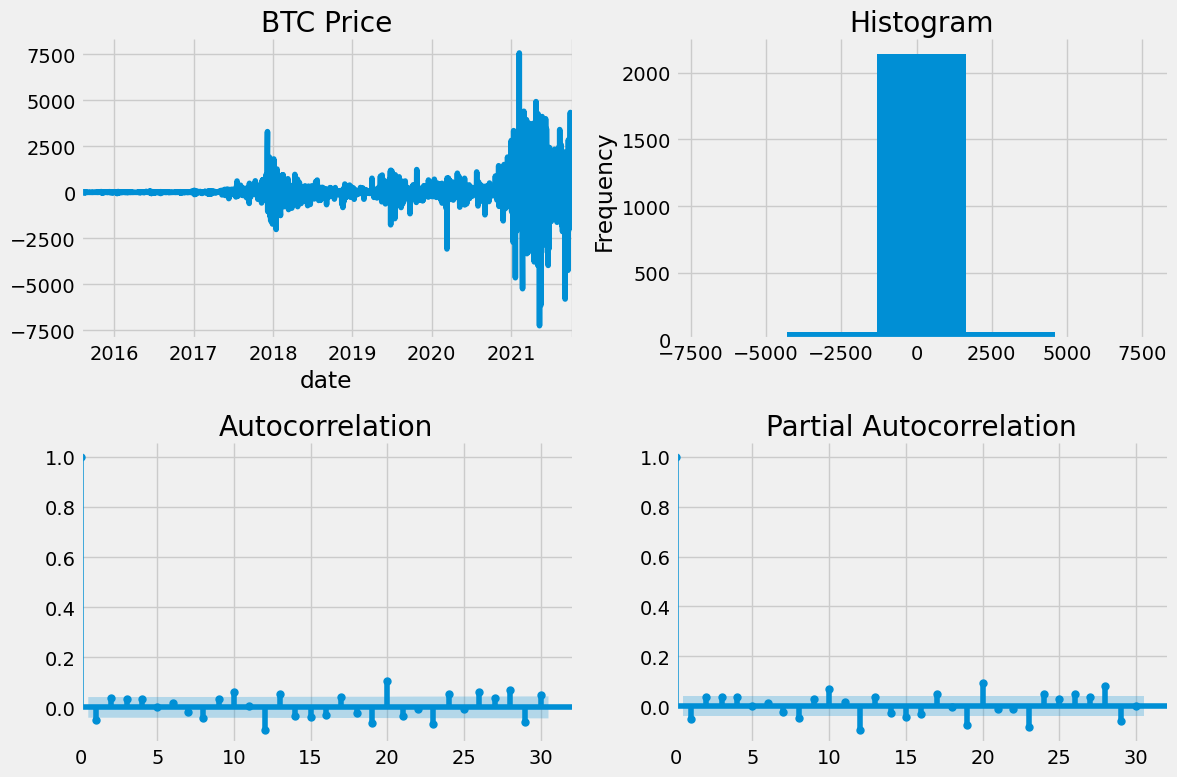

Wall time: 2.78 s


(<AxesSubplot:title={'center':'BTC Price'}, xlabel='date'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

In [12]:
%%time
tmplot(df.close_shift[1:],'BTC Price','BTC_Auto_Corr_Shift.png', lags=30,save=True)

In [13]:
#Set the data for modeling

#singlevar_columns = ['close']
singlediff_columns = ['close_shift']
#multivar_columns = ['volume','open','high','low']

In [14]:
# Scaling the training set
scalar = StandardScaler()
#minmax = MinMaxScaler()
X_train_scaled = scalar.fit_transform(df[singlediff_columns][1:])
#X_train_minmax = minmax.fit_transform(gme_data[singlevar_columns])#[1:])

In [15]:
%%time
#Format data (standard scaled)
samples = 10
train, test = train_test(X_train_scaled, .90)
X_train, y_train = process(train, samples)
X_test, y_test = process(test, samples)

Wall time: 26.5 ms


In [16]:
%%time
#Check shapes
print(X_train_scaled.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2262, 1)
(2025, 10, 1)
(2025, 1)
(217, 10, 1)
(217, 1)
Wall time: 3.97 ms


In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

METRICS = [
      keras.metrics.MeanSquaredError(name="MSE"),
      keras.metrics.RootMeanSquaredError(name="RMSE"),
      keras.metrics.MeanAbsoluteError(name="MAE"),
      keras.metrics.MeanAbsolutePercentageError(name="MAPE"),
      keras.metrics.MeanSquaredLogarithmicError(name="MSLE"),
]

def make_model(df, metrics=None):
    model = keras.Sequential([
      keras.layers.LSTM(10, activation='relu',input_shape=(df.shape[1],df.shape[2])),
      keras.layers.Dense(1),
    ])
    model.compile(
    optimizer='adam',
    loss='MSE',
    metrics=metrics)
    return model


In [18]:
%time
model = make_model(X_train, metrics=METRICS)
model.summary()

Wall time: 0 ns
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [19]:
%%time
epochs = 50
batch_size = 25

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='MAE', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

results = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)

Wall time: 52.9 s


In [20]:
results

[0.42410439252853394,
 0.42410439252853394,
 0.6512329578399658,
 0.27791619300842285,
 183.93788146972656,
 0.05958358570933342]

In [21]:
%%time
base_model = make_model(X_train, metrics=METRICS)
base_history = base_model.fit(X_train,
                              y_train, 
                              epochs=epochs, 
                              batch_size=batch_size,
                              callbacks=[early_stopping],
                              verbose=1)

Epoch 1/50
81/81 [==============================] - 21s 8ms/step - loss: 0.3529 - MSE: 0.4106 - RMSE: 0.6408 - MAE: 0.2764 - MAPE: 187.6269 - MSLE: 0.0560
Epoch 2/50
81/81 [==============================] - 1s 9ms/step - loss: 0.4268 - MSE: 0.4268 - RMSE: 0.6441 - MAE: 0.2633 - MAPE: 171.0436 - MSLE: 0.0495
Epoch 3/50
81/81 [==============================] - 1s 9ms/step - loss: 0.3830 - MSE: 0.3830 - RMSE: 0.6163 - MAE: 0.2699 - MAPE: 205.1198 - MSLE: 0.0493
Epoch 4/50
81/81 [==============================] - 1s 9ms/step - loss: 0.4086 - MSE: 0.4086 - RMSE: 0.6364 - MAE: 0.2672 - MAPE: 184.2016 - MSLE: 0.0470
Epoch 5/50
81/81 [==============================] - 1s 9ms/step - loss: 0.4343 - MSE: 0.4343 - RMSE: 0.6529 - MAE: 0.2752 - MAPE: 168.9420 - MSLE: 0.0491
Epoch 6/50
81/81 [==============================] - 1s 9ms/step - loss: 0.4905 - MSE: 0.4905 - RMSE: 0.6991 - MAE: 0.2913 - MAPE: 208.2222 - MSLE: 0.0586
Epoch 7/50
81/81 [==============================] - 1s 8ms/step - loss: 0.5

<Figure size 640x480 with 0 Axes>

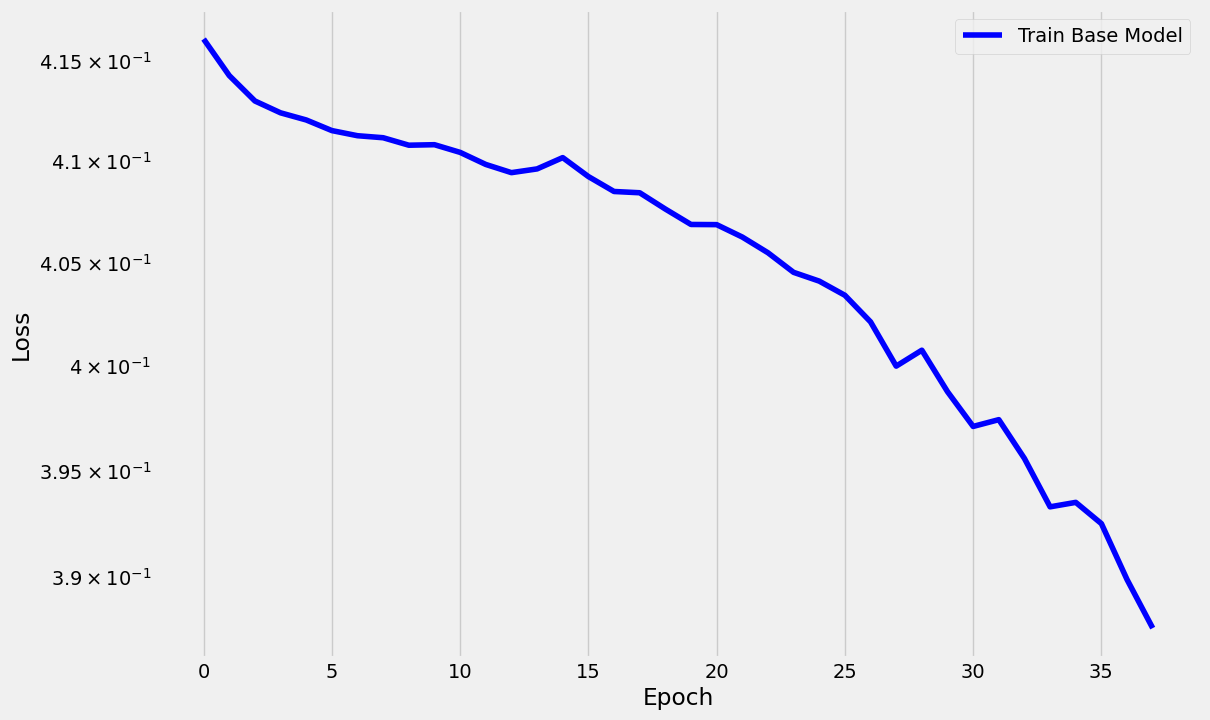

In [22]:
plot_loss(base_history, 'Base Model', 0)

In [23]:
#Reverse scaling
prediction_train = scalar.inverse_transform(base_model.predict(X_train, batch_size=batch_size))
prediction_test = scalar.inverse_transform(base_model.predict(X_test, batch_size=batch_size)) 

#Reshape 
prediction_train = prediction_train.reshape((-1))
prediction_test = prediction_test.reshape((-1))

In [24]:
%%time
pred = np.concatenate((prediction_train, prediction_test), axis=0)

Wall time: 0 ns


In [25]:
#Reverse differencing
pred = rev_dif(df.close, pred, interval=1)

In [26]:
result_df = pd.DataFrame(index=df.index[-len(pred):])
result_df['test'] = df.close[-len(pred):]
result_df['pred'] = pred
result_df['pred'] = result_df['pred'].round(decimals=2) 
result_df

,test,pred
date,,
2015-08-20,235.56,242.30
2015-08-21,232.85,239.66
2015-08-22,231.15,236.97
2015-08-23,229.21,235.57
2015-08-24,211.16,217.54
...,...,...
2021-10-04,49245.54,49175.96
2021-10-05,51493.99,51243.25
2021-10-06,55339.48,54951.47


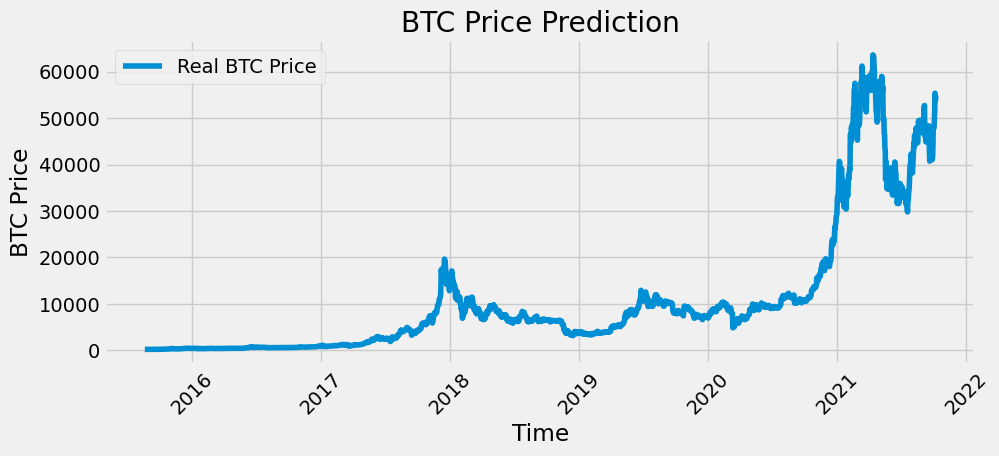

In [27]:
plot_predictions(result_df.test, result_df.pred)

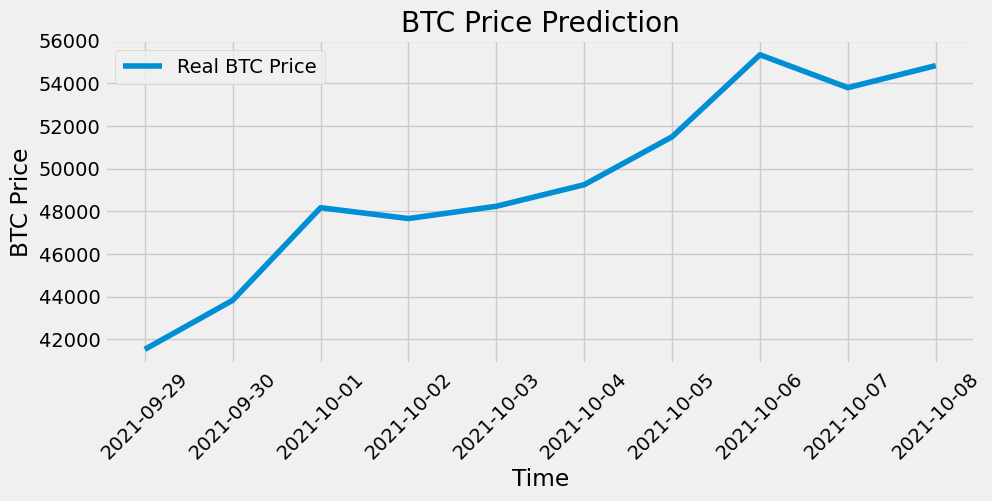

In [28]:
plot_predictions(result_df.test[-samples:], result_df.pred[-samples:])

In [29]:
from prettytable import PrettyTable
#Baseline Test Run 
ss_table_test = PrettyTable()
ss_table_test.field_names = ['Model Name','Mean Squared Error','Root Mean Squared Error','Mean Absolute Error','Mean Absolute % Error', 'Mean Squared Log Error']

ss_pred_test = base_model.predict(X_test, batch_size=batch_size)

ss_table_test.add_row([
    'Baseline LSTM',
    '{:.3f}'.format(base_history.history['MSE'][-1]),
    '{:.3f}'.format(base_history.history['RMSE'][-1]),
    '{:.3f}'.format(base_history.history['MAE'][-1]),
    '{:.3f}'.format(base_history.history['MAPE'][-1]),
    '{:.3f}'.format(base_history.history['MSLE'][-1])
])

print(ss_table_test)

+---------------+--------------------+-------------------------+---------------------+-----------------------+------------------------+
|   Model Name  | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | Mean Absolute % Error | Mean Squared Log Error |
+---------------+--------------------+-------------------------+---------------------+-----------------------+------------------------+
| Baseline LSTM |       0.388        |          0.623          |        0.272        |        370.017        |         0.047          |
+---------------+--------------------+-------------------------+---------------------+-----------------------+------------------------+


In [30]:
def predict(df, num_prediction, model):
    prediction_list = df[-samples:]

    for _ in range(num_prediction):
        x = prediction_list[-samples:]
        x = x.reshape((1, samples, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[samples-1:]
    return prediction_list

def predict_dates(num_prediction, df):
    last_date = df.index[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 21
forecast = predict(X_train_scaled, num_prediction, base_model)
forecast_dates = predict_dates(num_prediction, df)

In [31]:
forecast_df = pd.DataFrame(index=forecast_dates)
forecast_df['pred'] = scalar.inverse_transform(forecast)
forecast_df['pred'] = rev_diff_pred(df.close, forecast_df['pred'], interval=1)
#forecast_df['pred'] = forecast_df['pred'].round(decimals=2) 

In [32]:
forecast_df['pred'][0]

54832.21

In [37]:
#Next day prediction
forecast_df[:7]

,pred
2021-10-08,54832.210000
2021-10-09,54474.977655
2021-10-10,54208.854659
2021-10-11,53983.076057
2021-10-12,53800.630587
2021-10-13,53631.298376
2021-10-14,53483.482432


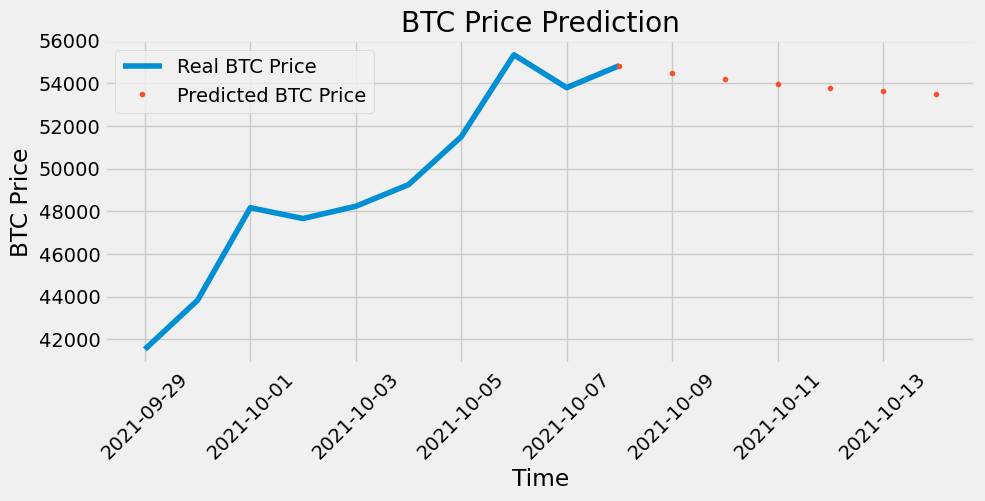

In [34]:
plot_predictions(result_df.test[-samples:],'Predictions.png', forecast_df[:7], save=True)

In [35]:
import altair as alt

In [36]:
data = df.reset_index()

open_close_color = alt.condition("datum.open <= datum.close",
                                 alt.value("#06982d"),
                                 alt.value("#ae1325"))

base = alt.Chart(data).encode(
    alt.X('date:T',
          axis=alt.Axis(
              format='%Y',
              labelAngle=-45,
              title='Date in 2009'
          )
    ),
    color=open_close_color
)

rule = base.mark_rule().encode(
    alt.Y(
        'low:Q',
        title='Price',
        scale=alt.Scale(zero=False),
    ),
    alt.Y2('high:Q')
)

bar = base.mark_bar().encode(
    alt.Y('open:Q'),
    alt.Y2('close:Q')
)

rule + bar

alt.LayerChart(...)